In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import pickle
from metrics import mean_Euclidean_dist, normalize
from pymoo.indicators.hv import HV
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from problem import get_problem

In [2]:
log_dir = f"logs_model"

color_code = ['green', 'blue', 'orange', 'red']

line_style = ['solid', 'dashed']

problem_names = ['DTLZ2', 'F2', 'VLMOP2']

models = [ 'MLP', 'Trans']

methods = ['Co-PSL', 'PSL-MOBO']

font_size = 10

n_dim = 6 

index = [4, 6, 8, 10, 12, 14, 16, 18, 20]

scatter_size = 10


In [3]:
def HV_compute():
    for problem_name in problem_names:
        n_dim = 6 
        problem = get_problem(problem_name)
        ref_point = problem.nadir_point 
        ref_point = [1.1 * x  for x in ref_point]
        hv = HV(ref_point=np.array(ref_point))
        
        for model in models:
            for method in methods:
                sol = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_{method}_{model}.npy')
                hv_result = []
                for i in range(sol.shape[0]): 
                    hv_result.append(hv(sol[:i])) 
                np.save(f'{log_dir}/HV_{problem_name}_Y_{n_dim}_{method}_{model}.npy', hv_result)    

/tmp/ipykernel_252050/106640486.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


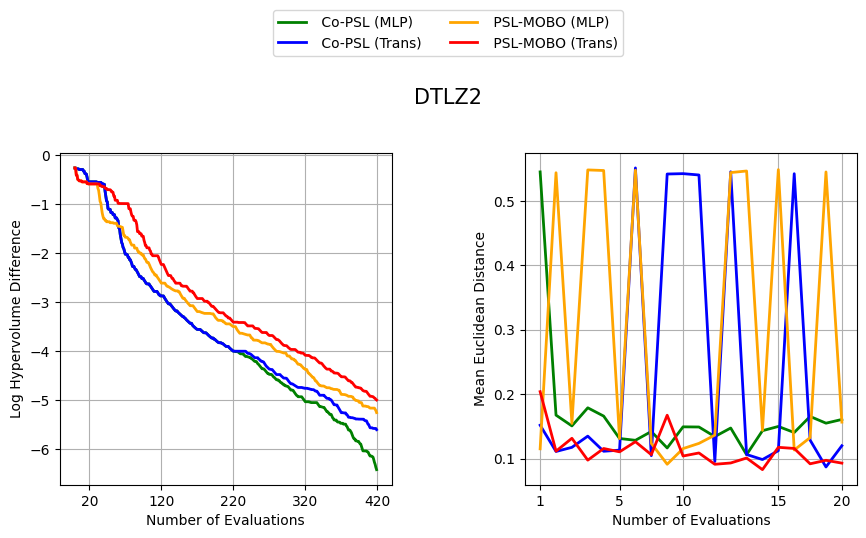

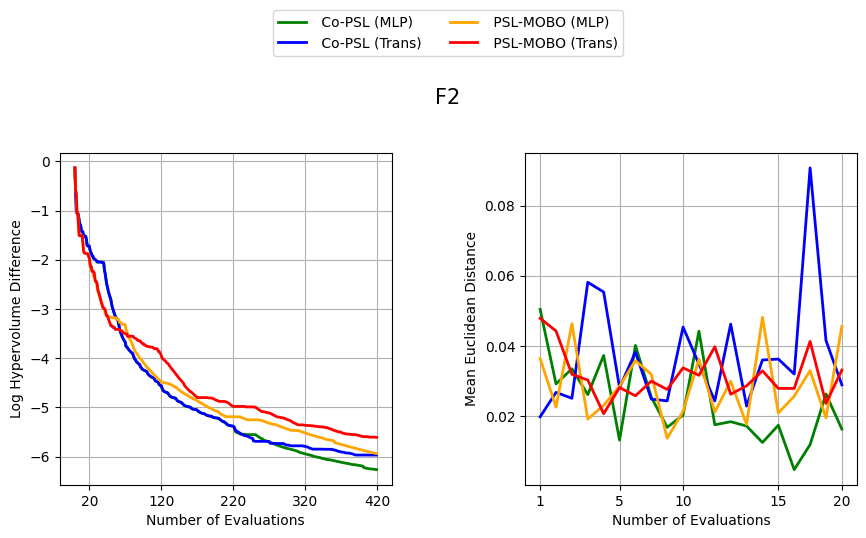

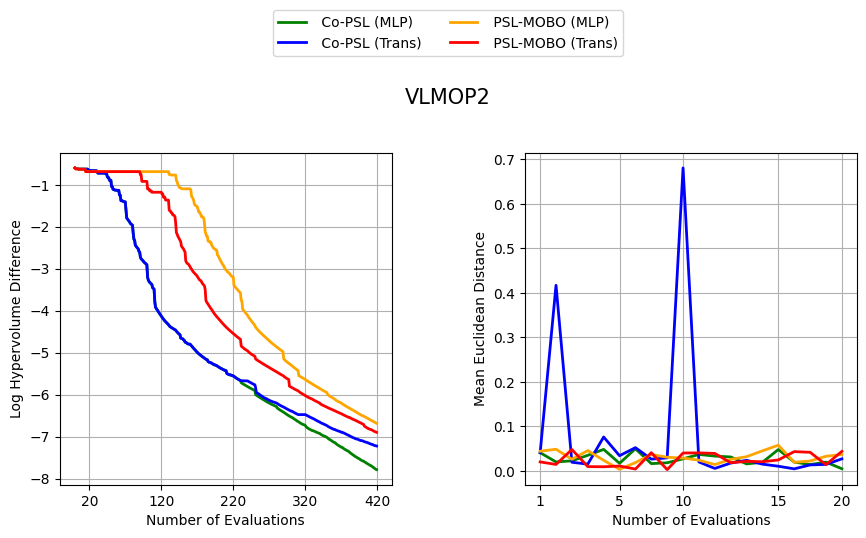

In [4]:
# HV_compute()

for problem_name in problem_names:
    fig, axs = plt.subplots(figsize = (10, 5), ncols = 2, nrows=1, layout="constrained")
    axs = axs.flatten()
    fig.tight_layout(pad=5.0)
    axs[0].set_box_aspect(1)
    axs[1].set_box_aspect(1)
    axs[0].grid()
    axs[1].grid()
    axs[0].set_ylabel("Log Hypervolume Difference")
    axs[0].set_xlabel("Number of Evaluations")
    axs[1].set_ylabel("Mean Euclidean Distance")
    axs[1].set_xlabel("Number of Evaluations")
    
    problem = get_problem(problem_name)
    
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    
    hv = HV(ref_point=np.array(ref_point))
    
    truth_pareto = np.load(f'{log_dir}/TrueParetoFront_{problem_name}.npy') 
    truth_front = np.load(f'{log_dir}/PrefParetoTruth_{problem_name}.npy')
    
    max_HV = hv(truth_pareto)
    
    count = 0
    for k, method in enumerate(methods):
        for u, model in enumerate(models):
            hv_results = np.load(f'{log_dir}/HV_{problem_name}_Y_{n_dim}_{method}_{model}.npy')
            LHV_score = np.log(np.clip(max_HV - hv_results, a_min=1e-14, a_max=max_HV))
            
            front_score = np.load(f"logs_model/front_{problem_name}_{n_dim}_{method}_{model}.npy")
            MED_score = []
            if method == "Co-PSL":
                for i in range(20):
                    MED_score.append(mean_Euclidean_dist(truth_front, front_score[i]))
            else:
                for i in range(20, 40):
                    MED_score.append(mean_Euclidean_dist(truth_front, front_score[i]))

            axs[0].plot(LHV_score, color=color_code[count], linewidth=2, label=f" {method} ({model})")
            axs[1].plot(MED_score, color=color_code[count], linewidth=2)
    
            count += 1

    axs[0].set_xticks([20, 120, 220, 320, 420])
    axs[1].set_xticks([0, 5, 9, 15, 19])
    axs[1].set_xticklabels([1, 5, 10, 15, 20], fontsize = font_size)
    fig.suptitle(f"{problem_name}", y = .98, fontsize=font_size*1.5)    
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncols=2, fontsize = font_size)
    plt.show()

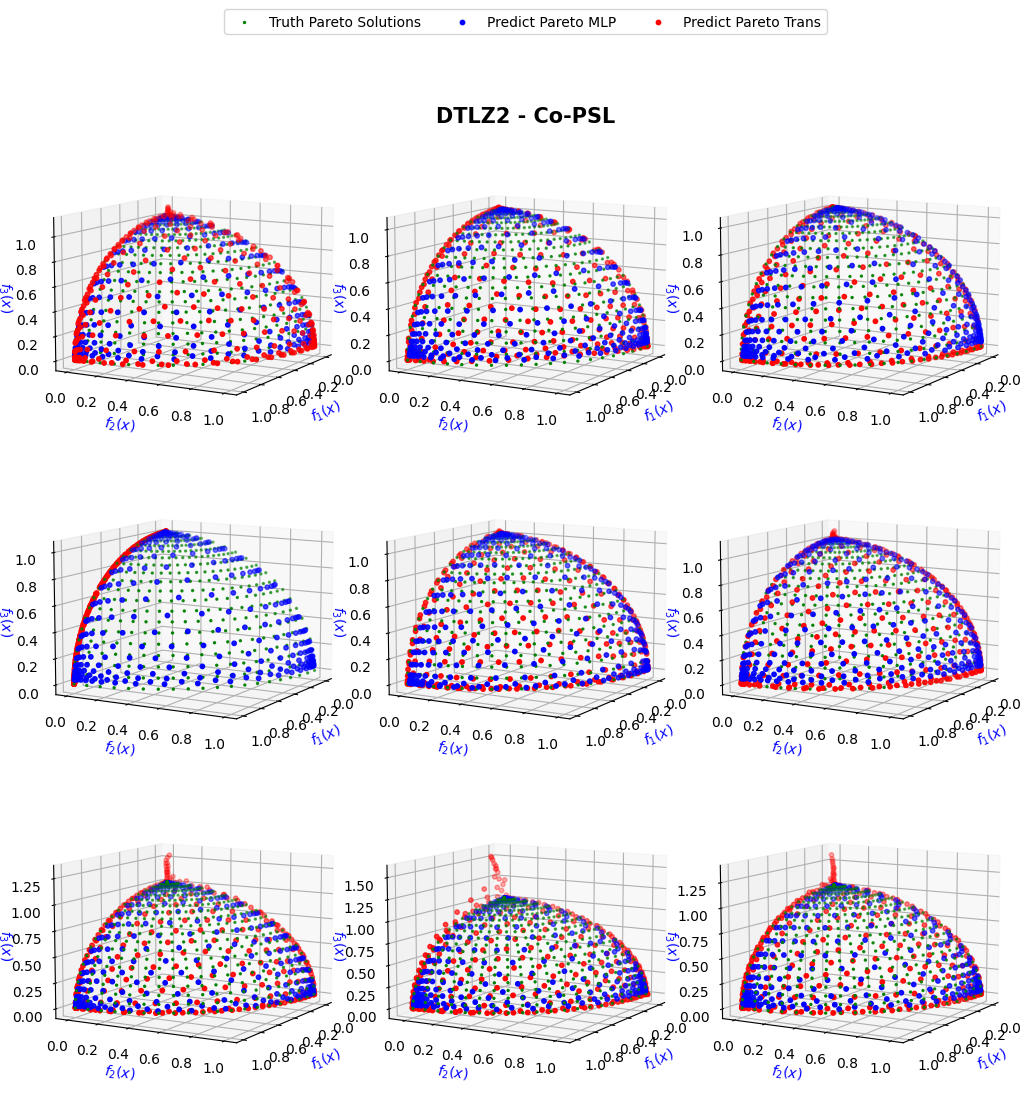

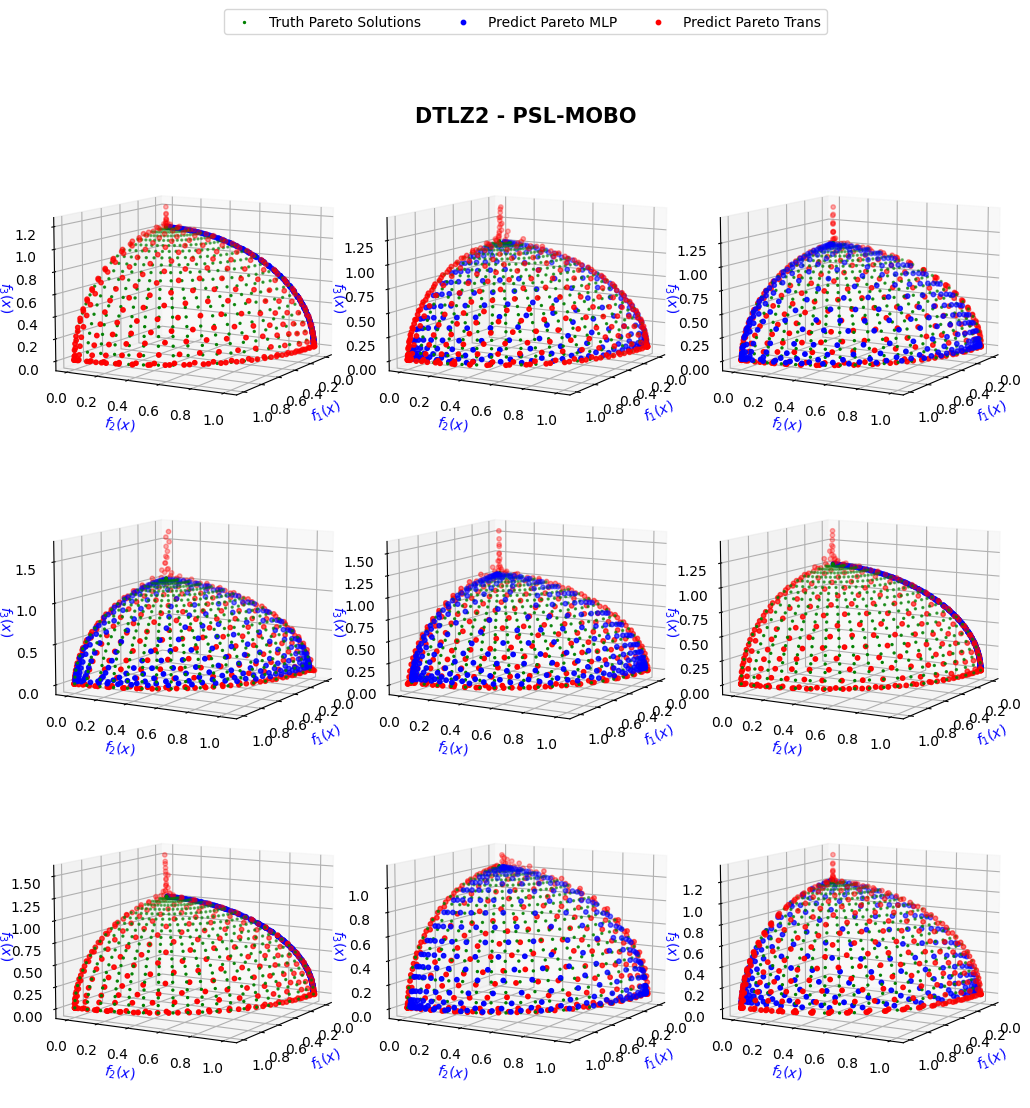

In [5]:
### DTLZ2

problem_name = 'DTLZ2'

for u, method in enumerate(methods):
    title = f"{problem_name} - {method}" 

    fig, axs = plt.subplots(figsize = (10, 10), ncols = int(len(index)/3), nrows=3, layout="constrained", subplot_kw=dict(projection='3d'))
    axs = axs.flatten()
    
    f_truth = np.load(f'{log_dir}/TrueParetoFront_{problem_name}.npy') 
    y_value = np.load(f"{log_dir}/y_{problem_name}_{n_dim}_{method}_{model}.npy")
    front_value_MLP = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{method}_MLP.npy")
    front_value_Trans = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{method}_Trans.npy")
    

    for i, ind in enumerate(index):       
        
        if method == 'PSL-MOBO': ind += 20
            
        y_truth, y_hat_MLP, y_hat_Trans = y_value[ind - 1], front_value_MLP[ind - 1], front_value_Trans[ind - 1]
        axs[i].view_init(elev=10., azim=30)
        axs[i].scatter(f_truth[:, 0], f_truth[:, 1], f_truth[:, 2], s=2 , zorder=1, color = "green", label = "Truth Pareto Solutions")
        axs[i].scatter(y_hat_MLP[:, 0], y_hat_MLP[:, 1], y_hat_MLP[:, 2], s=scatter_size, zorder=20, color = "blue", label = "Predict Pareto MLP")
        axs[i].scatter(y_hat_Trans[:, 0], y_hat_Trans[:, 1], y_hat_Trans[:, 2], s=scatter_size, zorder=20, color = "red", label = "Predict Pareto Trans")
        
        axs[i].set_xlabel(r'$f_1(x)$', color="blue")
        axs[i].set_ylabel(r'$f_2(x)$', color="blue")
        axs[i].set_zlabel(r'$f_3(x)$', rotation=0, color="blue")
        axs[i].zaxis.labelpad=-0.7
    fig.suptitle(f"{title}",fontweight="bold",fontsize=font_size + 5)
    fig.legend(*axs[1].get_legend_handles_labels(), bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3, fontsize=font_size)
    plt.show()

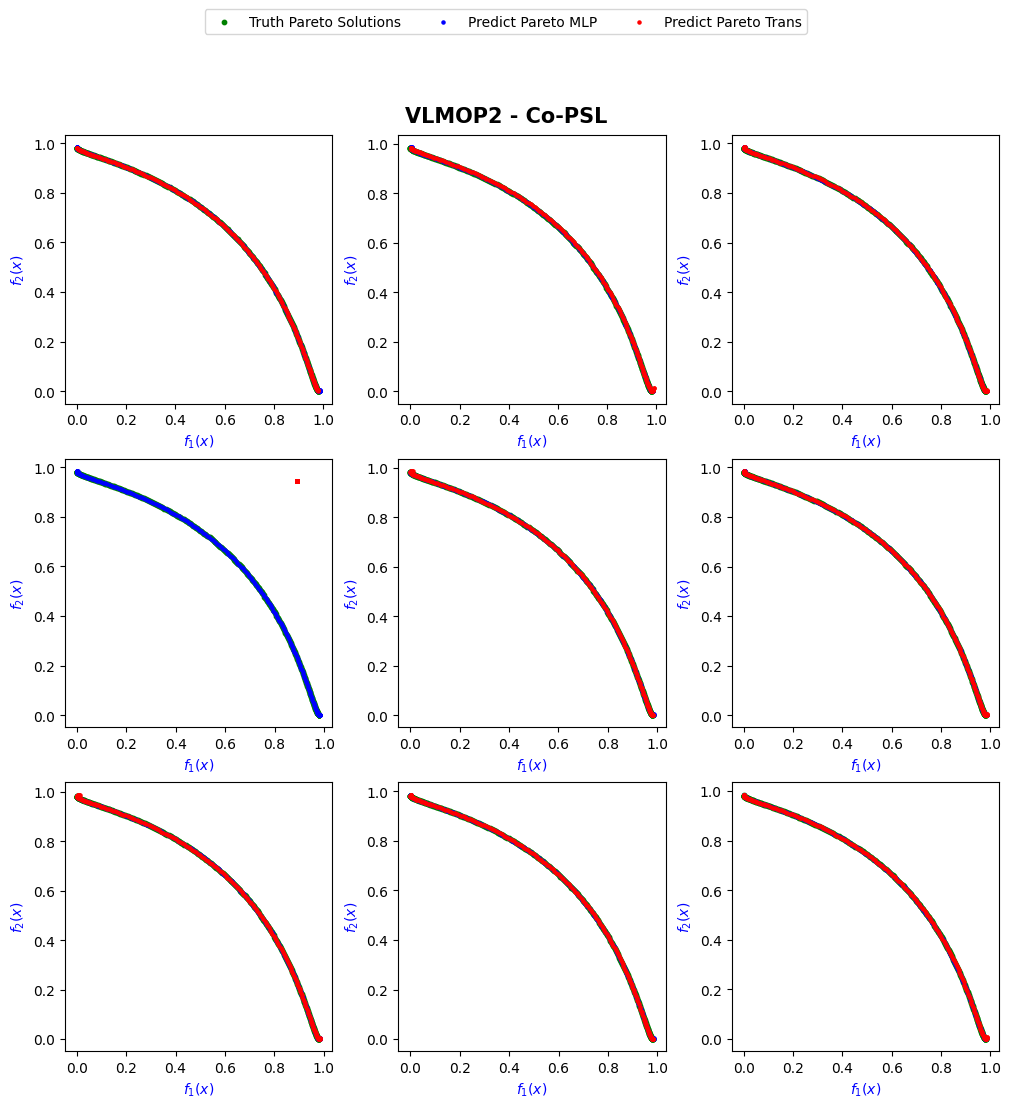

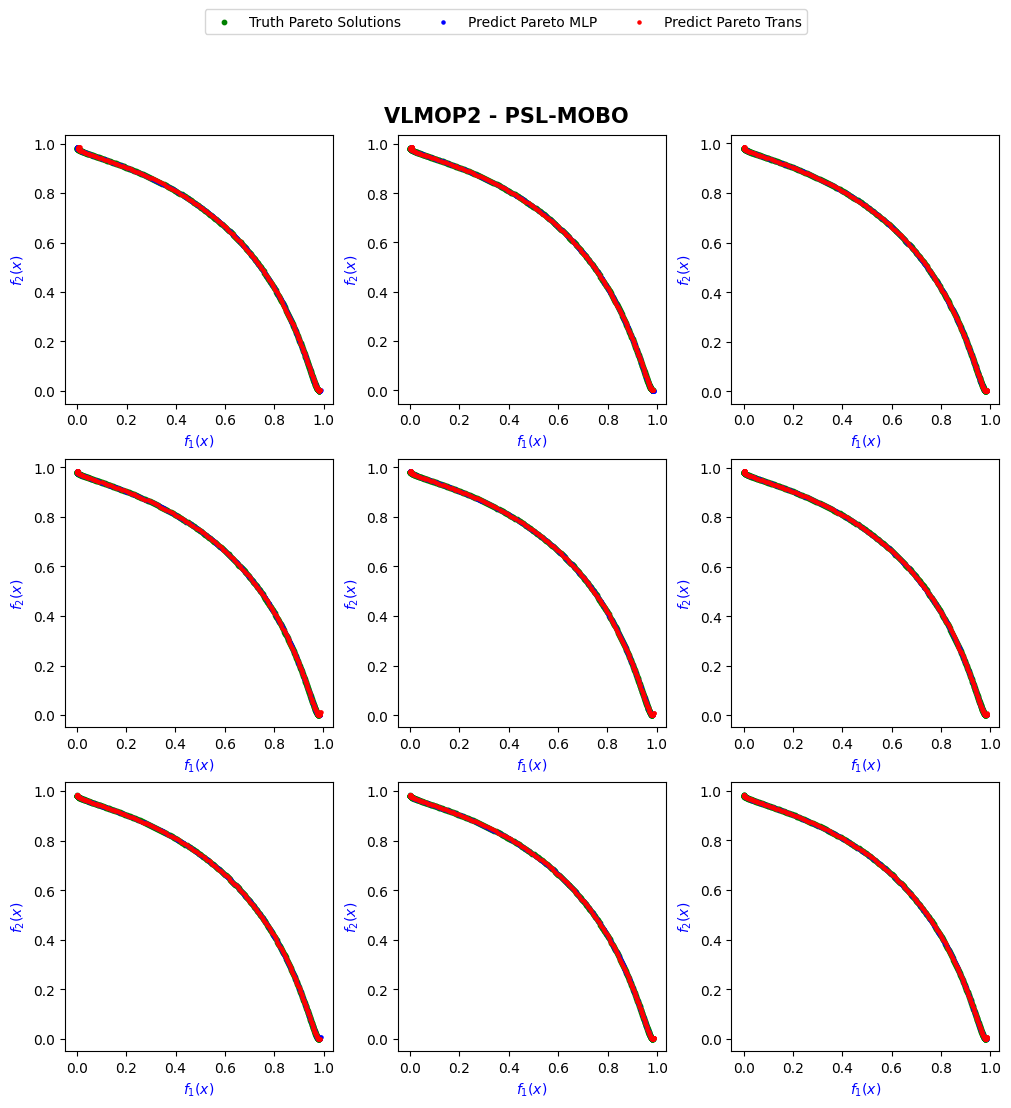

In [6]:
### VLMOP2

problem_name = 'VLMOP2'

for u, method in enumerate(methods):
    title = f"{problem_name} - {method}" 

    fig, axs = plt.subplots(figsize = (10, 10), ncols = int(len(index)/3), nrows=3, layout="constrained")
    axs = axs.flatten()
    
    f_truth = np.load(f'{log_dir}/TrueParetoFront_{problem_name}.npy') 
    y_value = np.load(f"{log_dir}/y_{problem_name}_{n_dim}_{method}_{model}.npy")
    front_value_MLP = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{method}_MLP.npy")
    front_value_Trans = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{method}_Trans.npy")

    for i, ind in enumerate(index):       
        
        if method == 'PSL-MOBO': ind += 20
            
        y_truth, y_hat_MLP, y_hat_Trans = y_value[ind - 1], front_value_MLP[ind - 1], front_value_Trans[ind - 1]
        axs[i].scatter(f_truth[:, 0], f_truth[:, 1], s=scatter_size , zorder=20, color = "green", label = "Truth Pareto Solutions")
        axs[i].scatter(y_hat_MLP[:, 0], y_hat_MLP[:, 1], s=scatter_size/2, zorder=20, color = "blue", label = "Predict Pareto MLP")
        axs[i].scatter(y_hat_Trans[:, 0], y_hat_Trans[:, 1], s=scatter_size/2, zorder=20, color = "red", label = "Predict Pareto Trans")
        
        axs[i].set_xlabel(r'$f_1(x)$', color="blue")
        axs[i].set_ylabel(r'$f_2(x)$', color="blue")
    fig.suptitle(f"{title}",fontweight="bold",fontsize=font_size + 5)
    fig.legend(*axs[1].get_legend_handles_labels(), bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3, fontsize=font_size)
    plt.show()

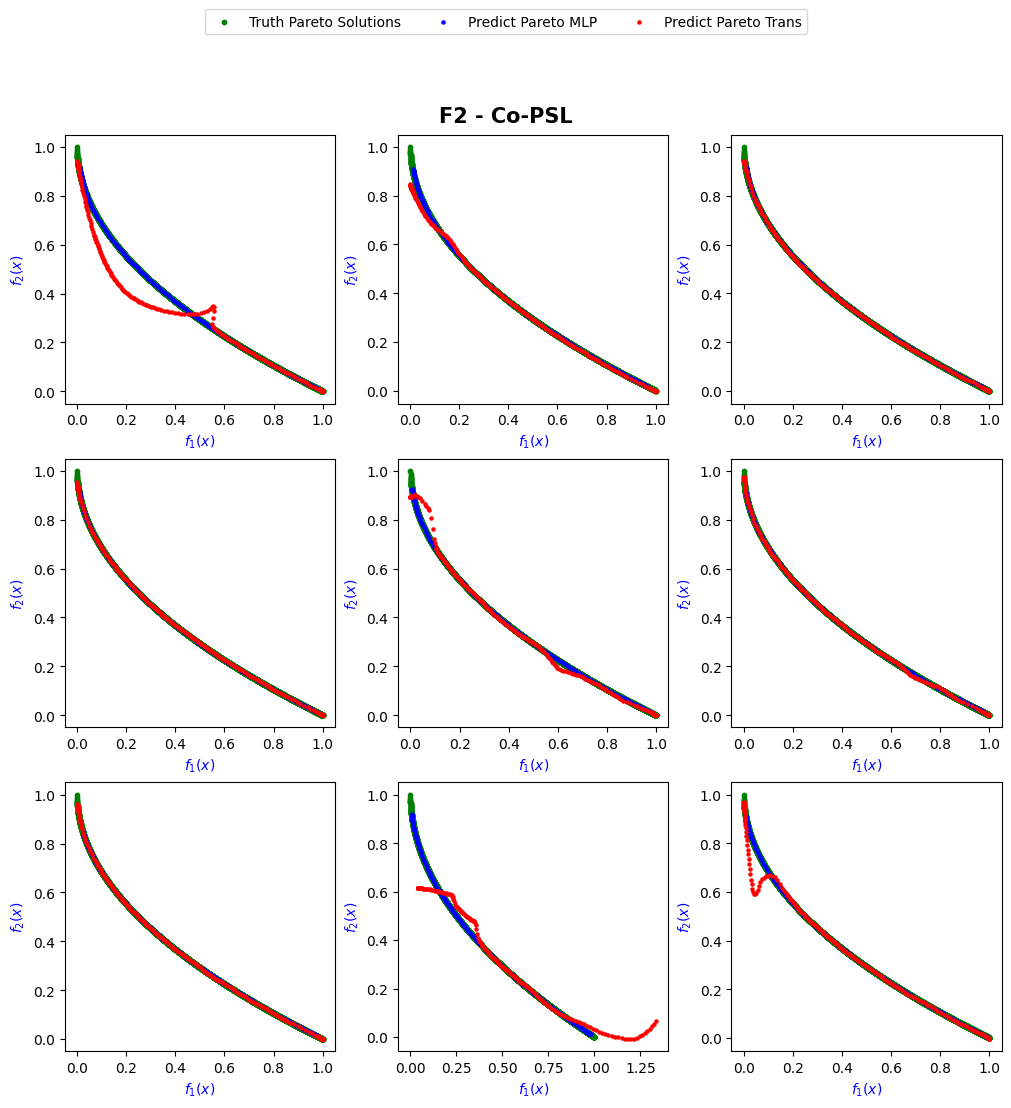

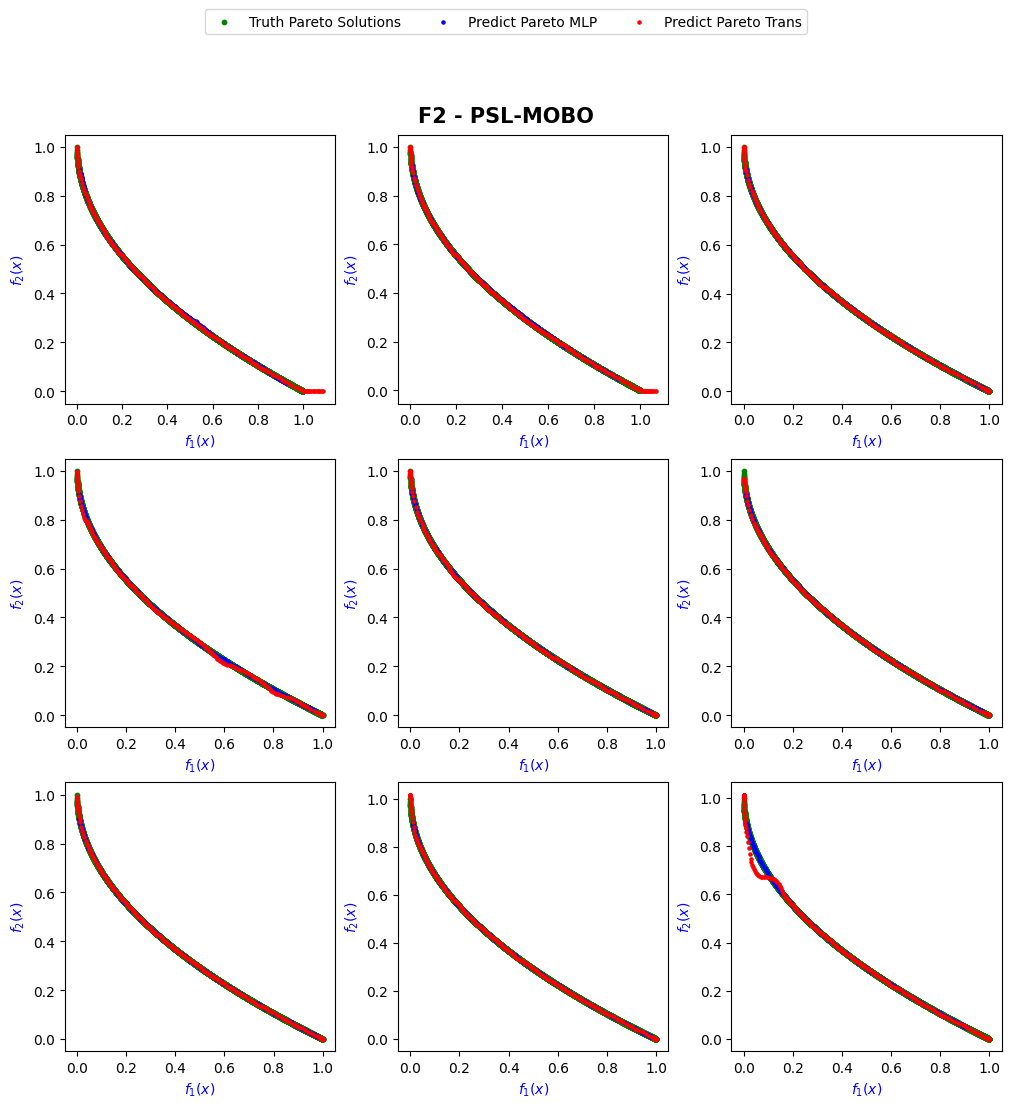

In [7]:
### F2

problem_name = 'F2'

for u, method in enumerate(methods):
    title = f"{problem_name} - {method}" 

    fig, axs = plt.subplots(figsize = (10, 10), ncols = int(len(index)/3), nrows=3, layout="constrained")
    axs = axs.flatten()
    
    f_truth = np.load(f'{log_dir}/TrueParetoFront_{problem_name}.npy') 
    y_value = np.load(f"{log_dir}/y_{problem_name}_{n_dim}_{method}_{model}.npy")
    front_value_MLP = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{method}_MLP.npy")
    front_value_Trans = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{method}_Trans.npy")

    for i, ind in enumerate(index):       
        
        if method == 'PSL-MOBO': ind += 20
            
        y_truth, y_hat_MLP, y_hat_Trans = y_value[ind - 1], front_value_MLP[ind - 1], front_value_Trans[ind - 1]
        axs[i].scatter(f_truth[:, 0], f_truth[:, 1], s=scatter_size , zorder=20, color = "green", label = "Truth Pareto Solutions")
        axs[i].scatter(y_hat_MLP[:, 0], y_hat_MLP[:, 1], s=scatter_size/2, zorder=20, color = "blue", label = "Predict Pareto MLP")
        axs[i].scatter(y_hat_Trans[:, 0], y_hat_Trans[:, 1], s=scatter_size/2, zorder=20, color = "red", label = "Predict Pareto Trans")
        
        axs[i].set_xlabel(r'$f_1(x)$', color="blue")
        axs[i].set_ylabel(r'$f_2(x)$', color="blue")
    fig.suptitle(f"{title}",fontweight="bold",fontsize=font_size + 5)
    fig.legend(*axs[1].get_legend_handles_labels(), bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3, fontsize=font_size)
    plt.show()